In [2]:
import torch
from visualise import visualise_v_quiver
import matplotlib.pyplot as plt

from utils import make_grid

from simulate import simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge

# Simulation of detailed divergence-free fields via the stream function/Lagrange function

- Also refer to [Wikipedia's stream function entry for more details](https://en.wikipedia.org/wiki/Stream_function)
- A stream function defines 2D scalar field. The curl of this scalar field yields a divergence-free (i.e. solenoidal) vector field. This vector field can be interpreted as a flow along the contours of scalar field, i.e. orthogonal to the gradient of the vector field. These contours are also referred to as streamlines. We exploit this relationship to simulate divergence-free fields for our experiments. 
- We compose stream fields of 
    - An basline stream field (BS) for the large-scale stream
    - An unnormalised Gaussian Mixture (UGM) to add detail

ToDo:
- check if we need to use Jacobians or if we can speed it up with just autograd

In [3]:
# define grid resolution
N_SIDE = 2**7 # 128

# use function defined in utils.py to create a grid
x_grid, x_long = make_grid(n_side = N_SIDE)

# Functions

- make a Gaussian mixture
- combine underlying stream and and Gaussian Mixture
- Generate divergence-free vector field
- 4 plots: GM, US, combined, vector field

In [4]:
def get_pdf_of_gaussian_component(x_grid, mu, sigma):
    """ Caluclate the probability density function (pdf) of a 2D Gaussian component at each point in the grid.
    p(x) = (1 / (2 * π * sqrt(det(Σ)))) * exp(-0.5 * (x - μ)ᵀ Σ⁻¹ (x - μ))

    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates
        mu (torch.Size([2])): mean location of the Gaussian component, should be within x_grid domain of course
        sigma (torch.Size([2, 2])): Covariance matrix of the Gaussian component

    Returns:
        pdf_grid (torch.Size([n_side, n_side])): pdf of the Gaussian component at each point in the grid
    """
    x_grid_flat = x_grid.view(-1, 2) # shape: (n_side**2, 2)
    diff = x_grid_flat - mu # shape: (n_side**2, 2)

    inv_sigma = torch.linalg.inv(sigma) # shape: (2, 2) - invert so we can multiply
    det_sigma = torch.linalg.det(sigma) # shape: (1,) - determinant is a scalar

    # Mahalanobis distance: (x - μ)ᵀ Σ⁻¹ (x - μ), for each x in the grid
    # Step 1: Matmul to get the intermediate result (N, D) @ (D, D) → (N, D)
    # Step 2: Mul is element-wise multiplication
    # Step 3: Sum over the last dimension to get the final result (N, D) → (N, 1)
    exponent = -0.5 * torch.sum(torch.mul(torch.matmul(diff, inv_sigma), diff), dim = 1)

    # sqrt(det(Σ)) is the square root of the determinant of the covariance matrix Σ.
    norm_multiplier = 1 / (2 * torch.pi * torch.sqrt(det_sigma))

    # Put it all together
    pdf_grid_flat = norm_multiplier * torch.exp(exponent) # shape: (n_side**2, 1)
    # Reshape to (n_side, n_side) i.e. grid
    pdf_grid = pdf_grid_flat.view(N_SIDE, N_SIDE) # shape: (n_side, n_side)

    return pdf_grid

def compose_unnormalised_gaussian_mixture(x_grid, mus, sigmas, weights):
    """ Compose an unnormalised Gaussian mixture (UGM) from multiple Gaussian components.

    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates
        mus (list of torch.Size([2])): list of mean locations of the Gaussian components
        sigmas (list of torch.Size([2, 2])): list of covariance matrices of the Gaussian components
        weights (list of float): list of weights for each Gaussian component

    Returns:
        pdf_grid (torch.Size([n_side, n_side])): pdf of the UGM at each point in the grid
    """
    # Extract grid size for intialisation of placeholder
    n_side = x_grid.shape[0] 

    # Unnormalised Gaussian Mixture Model (UGM) is a weighted sum of the individual Gaussian components
    ugm_grid = torch.zeros(n_side, n_side) # shape: (n_side, n_side)

    for mu, sigma, weight in zip(mus, sigmas, weights):
        ugm_grid += weight * get_pdf_of_gaussian_component(x_grid, mu, sigma)

    return ugm_grid

def get_directed_bls(x_grid, angle_degree):
    """
    Generate a linear stream function (scalar field) based on the x coordinate grid.
    The stream function is directed in a specified angle (in degrees).
    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates
        angle_degree (float): angle in degrees for the direction of the stream function
    Returns:
        directed_stream (torch.Size([n_side, n_side])): directed stream function at each point in the grid
    """
    # Convert the angle from degrees to radians
    angle_rad = torch.deg2rad(torch.tensor(angle_degree))

    a = torch.cos(angle_rad)  # x weight
    b = torch.sin(angle_rad)  # y weight

    # stream(x, y) = a * x + b * y
    directed_stream = a * x_grid[:, :, 0] + b * x_grid[:, :, 1] # shape: (n_side, n_side)
    
    return directed_stream

def combine_bls_and_ugm(bls_grid, ugm_grid, ugm_weight = 1.0):
    """ Combine the BLS and UGM grids to get the final grid. Both grids are assumed to be the same size.

    Args:
        bls_grid (torch.Size([n_side, n_side])): BLS grid
        ugm_grid (torch.Size([n_side, n_side])): UGM grid

    Returns:
        combined_grid (torch.Size([n_side, n_side])): combined grid
    """
    # Combine the BLS and UGM grids
    combined_grid = bls_grid + (ugm_weight * ugm_grid)

    return combined_grid

def get_vector_field_from_stream(x_grid, psi_grid):
    """ We use autograd to calculate the partial derivatives of the stream function and then compose the curl, i.e. the divergence-free vector field from it. 

    Note: 
    - Computing the full Jacobian is not necessary ("Jacobian overkill"), since we only need the partial derivatives of the stream function with respect to x and y. 
    - While at first glance it appears suprising that we can use the psi.sum() function to get a scalar output, this is because the gradient of a scalar function with respect to a vector is a vector, and psi[i, j] only depends on x[i, j], so the gradient is non-zero only for the i, j-th element of the x tensor.

    This would yield the same result as:
    grad_psi = torch.autograd.grad(
        outputs = psi, # non-scalar output
        inputs = x_grid,
        grad_outputs = torch.ones_like(psi)) 

    More background is provided here: https://discuss.pytorch.org/t/need-help-computing-gradient-of-the-output-with-respect-to-the-input/150950/4

    Alternative: torch.gradient() is based on finite differences, so it is not a perfect gradient operator.

    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates. Must have had requires_grad = True!!
        psi_grid (torch.Size([n_side, n_side])): psi stream function grid generated from x_grid

    Returns:
        vector_field (torch.Size([n_side, n_side, 2])): vector field at each point in the grid
    """
    grad_psi = torch.autograd.grad(
        outputs = psi_grid.sum(), # scalar, but only depends on corresponding x[i, j]
        inputs = x_grid, 
        )[0] # index 0 because we only have one input tensor

    # Calculate the vector field (curl) from the gradients: dψ/dy and -dψ/dx
    vector_field = torch.stack([grad_psi[:, :, 1], - grad_psi[:, :, 0]], dim = -1) # shape: (n_side, n_side, 2)

    return vector_field

## Plotting function

In [5]:
def make_four_plots(x_grid, ugm, bls, psi, vector_field):
    """ Make four plots: UGM, BLS, stream function and vector field.

    Args:
        x_grid (torch.Size([n_side, n_side, 2])): x coordinate grid where the last two dims are the x and y coordinates
        ugm (torch.Size([n_side, n_side])): UGM grid
        bls (torch.Size([n_side, n_side])): BLS grid
        psi (torch.Size([n_side, n_side])): stream function grid
        vector_field (torch.Size([n_side, n_side, 2])): vector field at each point in the grid
    """
    fig, ax = plt.subplots(1, 4, figsize = (20, 5), gridspec_kw = {'width_ratios': [1, 1, 1, 0.92]}) 

    # Plot UGM (Unnormalized Gaussian Mixture)
    c1 = ax[0].pcolormesh(ugm.detach(), cmap = 'viridis', shading = 'auto')
    cbar1 = fig.colorbar(c1, ax = ax[0], label = 'UGM Values', fraction = 0.046, pad = 0.04)  # fraction and pad sligns the height
    ax[0].set_title('UGM')
    ax[0].set_aspect('equal')

    # Plot BLS (Directed Bed Load Sediment Flux)
    c2 = ax[1].pcolormesh(bls.detach(), cmap = 'viridis', shading = 'auto')
    cbar2 = fig.colorbar(c2, ax = ax[1], label = 'BLS Values', fraction = 0.046, pad = 0.04)
    ax[1].set_title('BLS')
    ax[1].set_aspect('equal')

    # Plot Combined (UGM + BLS)
    c3 = ax[2].pcolormesh(psi.detach(), cmap = 'viridis', shading = 'auto')
    streamlines = ax[2].contour(psi.detach(), levels = 10, colors = 'black', linestyles = 'dashed', alpha = 0.8)
    cbar3 = fig.colorbar(c3, ax = ax[2], label = 'Psi combined Values', fraction = 0.046, pad = 0.04) 
    ax[2].set_title('Psi combined UGM and BLS')
    ax[2].set_aspect('equal')

    # Plot Quiver (Velocity Field)
    step = 6 # subsample

    ax[3].quiver(
        x_grid[::step, ::step, 0].detach(),  # x coordinates, subsampled
        x_grid[::step, ::step, 1].detach(),  # y coordinates, subsampled
        vector_field[::step, ::step, 0].detach(),  # u component of the field, subsampled
        vector_field[::step, ::step, 1].detach(),  # v component of the field, subsampled
        color = 'black',
    )
    ax[3].set_title('Quiver Plot of Gradients')
    ax[3].set_aspect('equal')


    # Remove ticks for all axes in the figure
    for a in ax:
        a.set_xticks([])  # Remove x-axis ticks
        a.set_yticks([])  # Remove y-axis ticks

    # Adjust layout to avoid overlap and ensure colorbars are same height
    plt.tight_layout()

    # Optional: You can adjust the space between subplots and colorbars
    plt.subplots_adjust(wspace = 0.2)  # Adjust horizontal space between plots

    # Show the plot
    plt.show()

## Define all inputs

In [6]:
## 
list_of_mus = [
    torch.tensor([0.3, 0.3]),
    torch.tensor([0.98, 0.9]),
    torch.tensor([0.3, 0.98])
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
    torch.tensor([[0.08, 0.0], [0.0, 0.05]]),
    torch.tensor([[0.2, 0.0], [0.0, 0.02]])
    ]

list_of_weights = [
    -0.1, 0.40, 0.20
    ] 

bsl_angle = 45
solid_ugm_weight = 0.5

In [7]:
## reproducing previous example
list_of_mus = [
    torch.tensor([0.2, 0.2]),
    torch.tensor([0.7, 0.9]),
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.1, 0.0], [0.0, 0.1]]),
    torch.tensor([[0.2, 0.0], [0.0, 0.2]]),
    ]

list_of_weights = [
    -0.1, 0.5
    ] 

bsl_angle = 90
solid_ugm_weight = 0.5

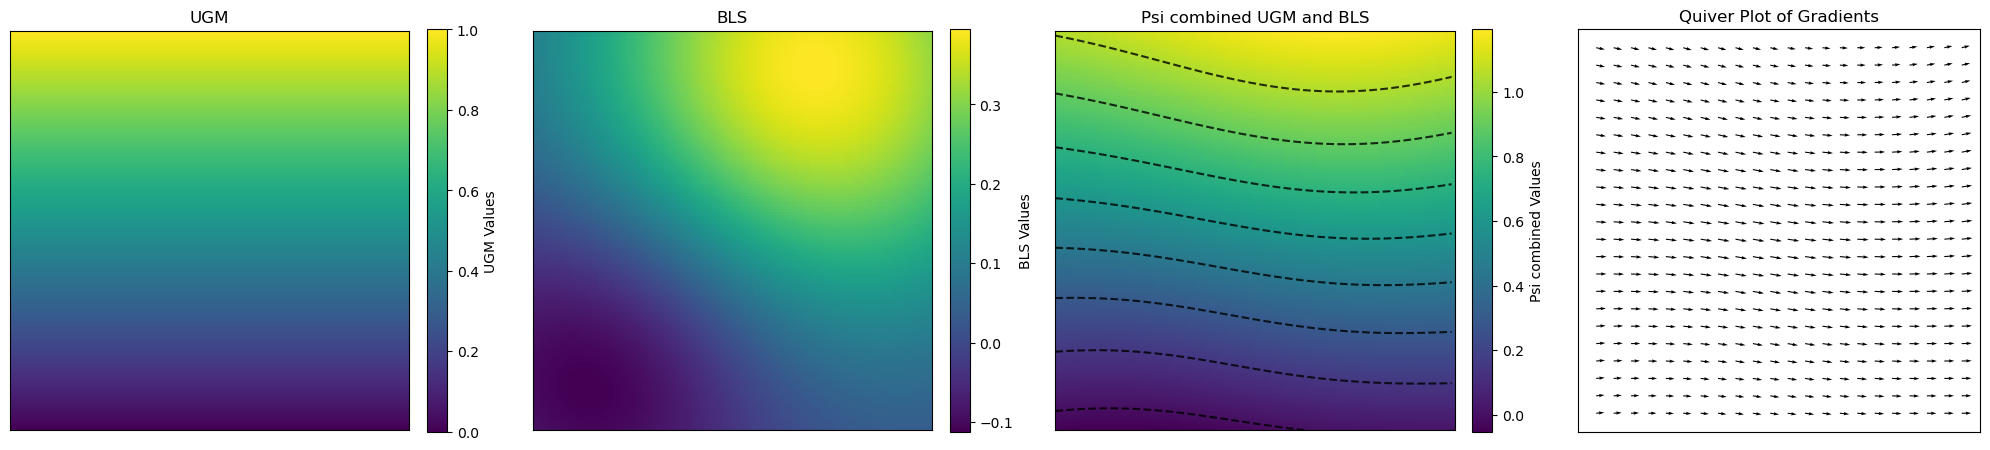

In [8]:
x_grid = x_grid.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl

ugm = compose_unnormalised_gaussian_mixture(
    x_grid,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

bls = get_directed_bls(x_grid, angle_degree = bsl_angle)

# stream function
psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight)

vector_field = get_vector_field_from_stream(x_grid, psi)

make_four_plots(x_grid, bls, ugm, psi, vector_field)

# (1) Interesting deflection

In [42]:
## reproducing previous example
list_of_mus = [
    torch.tensor([0.3, 0.7]),
    torch.tensor([0.9, 0.1]),
    torch.tensor([0.05, 0.05]),
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.05, 0.02], [0.002, 0.01]]),
    torch.tensor([[0.2, 0.0], [0.0, 0.1]]),
    torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
    ]

list_of_weights = [
    0.2, 
    -1.5,
    1.0
    ] 

bsl_angle = 0
solid_ugm_weight = 0.2

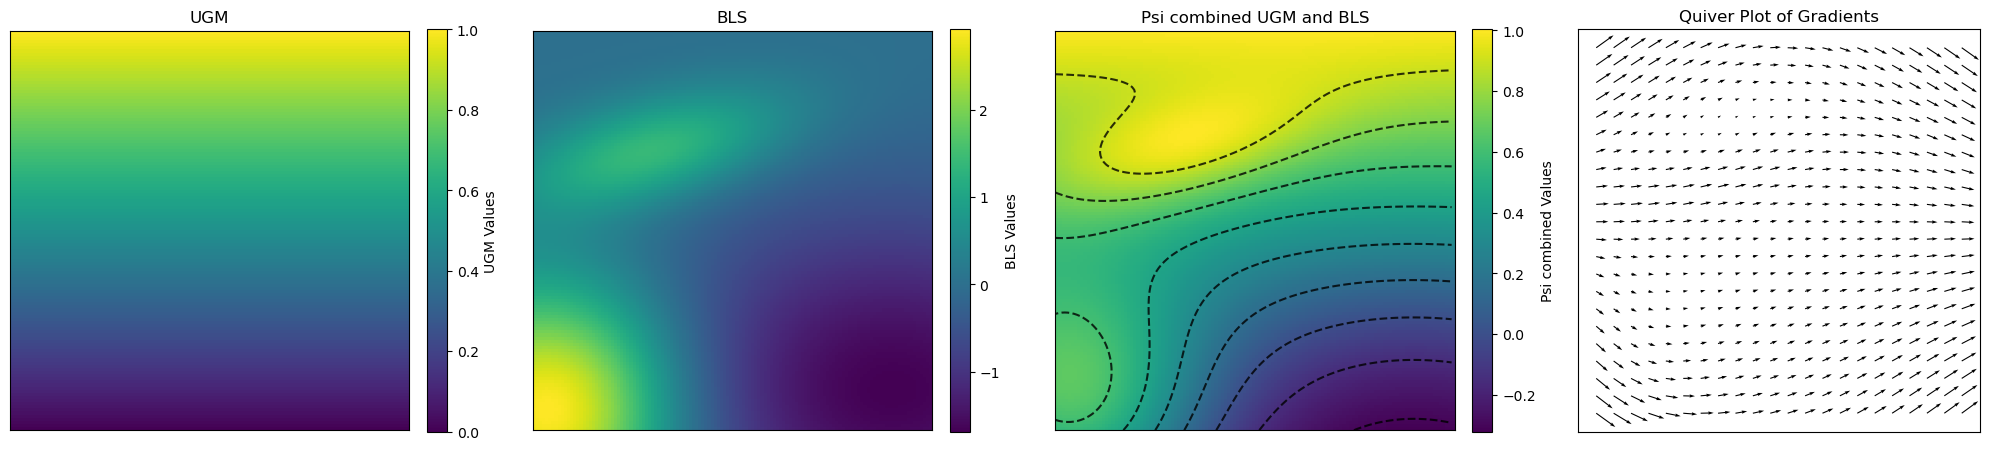

In [43]:
x_grid = x_grid.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl

ugm = compose_unnormalised_gaussian_mixture(
    x_grid,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

bls = get_directed_bls(x_grid, angle_degree = 90)
                          
# stream function
psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight)

vector_field = get_vector_field_from_stream(x_grid, psi)

simulated_vector_field = simulate_deflection(x_grid.reshape(-1, 2)).reshape(N_SIDE, N_SIDE, 2)

vector_field = vector_field * 0.4 + simulated_vector_field 

make_four_plots(x_grid, bls, ugm, psi, vector_field)

# Write a function where this works for any input x

In [ ]:
# Data is in long format
x_input = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False)

In [ ]:
def get_pdf_of_gaussian_component_long(x, mu, sigma):
    """ Caluclate the probability density function (pdf) of a 2D Gaussian component at each point.
    p(x) = (1 / (2 * π * sqrt(det(Σ)))) * exp(-0.5 * (x - μ)ᵀ Σ⁻¹ (x - μ))

    Args:
        x (torch.Size([n, 2])): x points where the last two dims are the x and y coordinates
        mu (torch.Size([2])): mean location of the Gaussian component, should be within (or near) x domain of course
        sigma (torch.Size([2, 2])): Covariance matrix of the Gaussian component

    Returns:
        pdf (torch.Size([n])): pdf of the Gaussian component at each point 
    """
    diff = x - mu # shape: (n, 2)

    inv_sigma = torch.linalg.inv(sigma) # shape: (2, 2) - invert so we can multiply
    det_sigma = torch.linalg.det(sigma) # shape: (1,) - determinant is a scalar

    # Mahalanobis distance: (x - μ)ᵀ Σ⁻¹ (x - μ), for each x in the grid
    # Step 1: Matmul to get the intermediate result (N, D) @ (D, D) → (N, D)
    # Step 2: Mul is element-wise multiplication
    # Step 3: Sum over the last dimension to get the final result (N, D) → (N, 1)
    exponent = -0.5 * torch.sum(torch.mul(torch.matmul(diff, inv_sigma), diff), dim = 1)

    # sqrt(det(Σ)) is the square root of the determinant of the covariance matrix Σ.
    norm_multiplier = 1 / (2 * torch.pi * torch.sqrt(det_sigma))

    # Put it all together
    pdf = norm_multiplier * torch.exp(exponent) # shape: (n, 1)

    return pdf

def compose_unnormalised_gaussian_mixture_long(x, mus, sigmas, weights):
    """ Compose an unnormalised Gaussian mixture (UGM) from multiple Gaussian components. Returns a vector of the same length as x.

    Args:
        x (torch.Size([n, 2])): list of n points in 2D where the last two dims are the x and y coordinates
        mus (list of torch.Size([2])): list of mean locations of the Gaussian components
        sigmas (list of torch.Size([2, 2])): list of covariance matrices of the Gaussian components
        weights (list of float): list of weights for each Gaussian component

    Returns:
        pdf (torch.Size([n])): pdf of the UGM at each point
    """
    # Extract length for intialisation of placeholder
    n = x.shape[0] 

    # Unnormalised Gaussian Mixture Model (UGM) is a weighted sum of the individual Gaussian components
    ugm = torch.zeros(n) # shape: (n, )

    for mu, sigma, weight in zip(mus, sigmas, weights):
        ugm += weight * get_pdf_of_gaussian_component_long(x, mu, sigma)

    return ugm

def get_directed_bls_long(x, angle_degree):
    """
    Generate a linear stream function (scalar field) based on the x coordinates
    The stream function is directed in a specified angle (in degrees).
    Args:
        x (torch.Size([n, 2])): x coordinate list where the last two dims are the x and y coordinates
        angle_degree (float): angle in degrees for the direction of the stream function
    Returns:
        directed_stream (torch.Size([n])): directed stream function at each point
    """
    # Convert the angle from degrees to radians
    angle_rad = torch.deg2rad(torch.tensor(angle_degree))

    a = torch.cos(angle_rad)  # x weight
    b = torch.sin(angle_rad)  # y weight

    # stream(x, y) = a * x + b * y
    directed_stream = a * x[:, 0] + b * x[:, 1] # shape: (n)
    
    return directed_stream

def combine_bls_and_ugm(bls, ugm, ugm_weight = 1.0):
    """ Combine the BLS and UGM grids to get the final grid. Both grids are assumed to be the same size.

    Args:
        bls (torch.Size([n_side, n_side]) or torch.Size([n])): BLS grid/long list
        ugm (torch.Size([n_side, n_side]) or torch.Size([n]): UGM grid/long list

    Returns:
        combined_grid (torch.Size([n_side, n_side]) or torch.Size([n]): combined grid/long list
    """
    # Combine the BLS and UGM grids/components
    combined = bls + (ugm_weight * ugm)

    return combined

def get_vector_field_from_stream_long(x, psi):
    """ We use autograd to calculate the partial derivatives of the stream function and then compose the curl, i.e. the divergence-free vector field from it. 

    Note: 
    - Computing the full Jacobian is not necessary ("Jacobian overkill"), since we only need the partial derivatives of the stream function with respect to x and y. 
    - While at first glance it appears suprising that we can use the psi.sum() function to get a scalar output, this is because the gradient of a scalar function with respect to a vector is a vector, and psi[i, j] only depends on x[i, j], so the gradient is non-zero only for the i, j-th element of the x tensor.

    This would yield the same result as:
    grad_psi = torch.autograd.grad(
        outputs = psi, # non-scalar output
        inputs = x_grid,
        grad_outputs = torch.ones_like(psi)) 

    More background is provided here: https://discuss.pytorch.org/t/need-help-computing-gradient-of-the-output-with-respect-to-the-input/150950/4

    Alternative: torch.gradient() is based on finite differences, so it is not a perfect gradient operator.

    Args:
        x (torch.Size([n, 2])): x coordinate list where the last two dims are the x and y coordinates. Must have had requires_grad = True!!
        psi (torch.Size([n])): psi stream function generated from x

    Returns:
        vector_field (torch.Size([n, 2])): vector field at each point
    """
    grad_psi = torch.autograd.grad(
        outputs = psi.sum(), # scalar, but only depends on corresponding x[i, j]
        inputs = x, 
        )[0] # index 0 because we only have one input tensor

    # Calculate the vector field (curl) from the gradients: dψ/dy and -dψ/dx
    vector_field = torch.stack([grad_psi[:, 1], - grad_psi[:, 0]], dim = -1) # shape: (n, 2)

    return vector_field

def simulate_detailed_deflection(x_inputs):
    # mean magnitude is 1.47
    ### Fixed ###
    list_of_mus = [
        torch.tensor([0.3, 0.7]),
        torch.tensor([0.9, 0.1]),
        torch.tensor([0.05, 0.05]),
        ]

    # Covariance matrices for each Gaussian component
    list_of_sigmas = [
        torch.tensor([[0.05, 0.02], [0.002, 0.01]]),
        torch.tensor([[0.2, 0.0], [0.0, 0.1]]),
        torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
        ]

    list_of_weights = [
        0.2, 
        -1.5,
        1.0
        ] 

    solid_ugm_weight = 0.2
    
    ###
    x_inputs = x_inputs.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl
    
    # produce Unnormalised Gaussian Mixture component 
    ugm = compose_unnormalised_gaussian_mixture_long(
        x_inputs,
        list_of_mus,
        list_of_sigmas,
        list_of_weights
    ) # shape: (n)
    
    # produce baseline stream field
    bls = get_directed_bls_long(x_inputs, angle_degree = 90) # shape: (n)

    # stream function: weighted sum of the BLS and UGM
    psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight) # shape: (n)

    psi_vector_field = get_vector_field_from_stream_long(x_inputs, psi) # shape: (n, 2)

    simulated_vector_field = simulate_deflection(x_inputs.detach().clone()) # torch.Size([n, 2])

    vector_field = psi_vector_field * 0.4 + simulated_vector_field # torch.Size([n, 2])

    return vector_field

In [ ]:
def simulate_detailed_curve(x_inputs):
    # mean magnitude is 1.57

    ### Fixed ###
    list_of_mus = [
        torch.tensor([0.4, 0.7]),
        torch.tensor([0.2, -0.05]),
        ]

    # Covariance matrices for each Gaussian component
    # Smaller: Lower variance (more concentrated) in that direction
    # Off-diagonal elements: Correlation between x and y
    list_of_sigmas = [
        torch.tensor([[0.05, 0.03], [0.002, 0.01]]),
        torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
        ]

    list_of_weights = [
        0.2, 
        -1.0
        ] 

    solid_ugm_weight = 0.5
    
    ###
    x_inputs = x_inputs.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl
    
    # produce Unnormalised Gaussian Mixture component 
    ugm = compose_unnormalised_gaussian_mixture_long(
        x_inputs,
        list_of_mus,
        list_of_sigmas,
        list_of_weights
    ) # shape: (n)
    
    # produce baseline stream field
    bls = get_directed_bls_long(x_inputs, angle_degree = 90) # shape: (n)

    # stream function: weighted sum of the BLS and UGM
    psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight) # shape: (n)

    psi_vector_field = get_vector_field_from_stream_long(x_inputs, psi) # shape: (n, 2)

    simulated_vector_field = simulate_merge(x_inputs.detach().clone()) # torch.Size([n, 2])

    vector_field = psi_vector_field * 0.2 + simulated_vector_field # torch.Size([n, 2])

    return vector_field

In [77]:
def simulate_detailed_convergence(x_inputs):
    # mean magnitude is 1.57

    ### Fixed ###
    list_of_mus = [
        torch.tensor([0.2, 0.3]),
        torch.tensor([0.5, 1.0]),
        ]

    list_of_sigmas = [
        torch.tensor([[0.05, 0.0], [0.01, 0.05]]),
        torch.tensor([[0.2, 0.0], [0.0, 0.1]]),
        ]

    list_of_weights = [
        -0.2, 
        1.2,
        ] 

    solid_ugm_weight = 0.5
    
    ###
    x_inputs = x_inputs.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl
    
    # produce Unnormalised Gaussian Mixture component 
    ugm = compose_unnormalised_gaussian_mixture_long(
        x_inputs,
        list_of_mus,
        list_of_sigmas,
        list_of_weights
    ) # shape: (n)
    
    # produce baseline stream field
    bls = get_directed_bls_long(x_inputs, angle_degree = 90) # shape: (n)

    # stream function: weighted sum of the BLS and UGM
    psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight) # shape: (n)

    psi_vector_field = get_vector_field_from_stream_long(x_inputs, psi) # shape: (n, 2)

    simulated_vector_field = simulate_convergence(x_inputs.detach().clone()) # torch.Size([n, 2])

    vector_field = psi_vector_field * 0.4 + simulated_vector_field # torch.Size([n, 2])

    return vector_field

In [ ]:
def simulate_detailed_ridges(x_inputs):
    # mean magnitude is 1.47

    ### Fixed ###
    list_of_mus = [
        torch.tensor([0.2, 0.3]),
        torch.tensor([0.5, 1.0]),
        torch.tensor([1.0, 0.7]),
        torch.tensor([1.0, 0.2]),
        ]

    list_of_sigmas = [
        torch.tensor([[0.05, 0.0], [0.01, 0.1]]),
        torch.tensor([[0.2, 0.0], [0.0, 0.1]]),
        torch.tensor([[0.3, 0.0], [0.0, 0.01]]),
        torch.tensor([[0.3, 0.0], [0.0, 0.01]]),
        ]

    list_of_weights = [
        -0.2, 
        1.2,
        0.2,
        0.2
        ] 

    solid_ugm_weight = 0.1
    
    ###
    x_inputs = x_inputs.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl
    
    # produce Unnormalised Gaussian Mixture component 
    ugm = compose_unnormalised_gaussian_mixture_long(
        x_inputs,
        list_of_mus,
        list_of_sigmas,
        list_of_weights
    ) # shape: (n)

    # different way of producing baseline streamfield
    bls = (x_inputs[:, 0] + 0.2 * x_inputs[:, 1])**3 # shape: (n)
                          
    # stream function: weighted sum of the BLS and UGM
    psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight) # shape: (n)

    psi_vector_field = get_vector_field_from_stream_long(x_inputs, psi) # shape: (n, 2)

    # no simulated vector field needed

    return psi_vector_field

In [ ]:
def simulate_detailed_branching(x_inputs):
    # mean magnitude is 1.0

    list_of_mus = [
        torch.tensor([0.0, -0.1]),
        torch.tensor([0.5, 1.0]),
        torch.tensor([1.0, 0.7]),
        torch.tensor([0.5, 0.5]),
        torch.tensor([0.8, 0.2]),
        ]

    list_of_sigmas = [
        torch.tensor([[0.003, 0.0], [0.0, 0.04]]),
        torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
        torch.tensor([[0.3, 0.0], [0.0, 0.01]]),
        torch.tensor([[0.006, 0.0], [0.008, 0.004]]),
        torch.tensor([[0.004, 0.004], [0.0, 0.006]]),
        ]

    list_of_weights = [
        - 0.8, 
        0.5,
        0.3,
        0.03,
        -0.03
        ] 

    solid_ugm_weight = 0.2
    
    ###
    x_inputs = x_inputs.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl
    
    # produce Unnormalised Gaussian Mixture component 
    ugm = compose_unnormalised_gaussian_mixture_long(
        x_inputs,
        list_of_mus,
        list_of_sigmas,
        list_of_weights
    ) # shape: (n)

    # produce baseline stream field
    bls = get_directed_bls_long(x_inputs, angle_degree = 1) # shape: (n)

    # stream function: weighted sum of the BLS and UGM
    psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight) # shape: (n)

    psi_vector_field = get_vector_field_from_stream_long(x_inputs, psi) # shape: (n, 2)

    simulated_vector_field = simulate_branching(x_inputs.detach().clone()) # torch.Size([n, 2])

    vector_field = psi_vector_field * 0.1 + simulated_vector_field # torch.Size([n, 2])

    return vector_field

In [ ]:
_, x_test = make_grid(30)

x_train_curve = simulate_detailed_curve(x_input)
x_test_curve = simulate_detailed_curve(x_test)

magnitudes = torch.linalg.norm(x_test_curve, dim = 1)
mean_magnitude = magnitudes.mean()
print(mean_magnitude)

In [78]:
_, x_test = make_grid(30)

x_train_convergence = simulate_detailed_convergence(x_input)
x_test_convergence = simulate_detailed_convergence(x_test)

magnitudes = torch.linalg.norm(x_test_convergence, dim = 1)
mean_magnitude = magnitudes.mean()
print(mean_magnitude)

tensor(1.2906)


In [83]:
_, x_test = make_grid(30)

x_train_ridges = simulate_detailed_ridges(x_input)
x_test_ridges = simulate_detailed_ridges(x_test)

magnitudes = torch.linalg.norm(x_test_ridges, dim = 1)
mean_magnitude = magnitudes.mean()
print(mean_magnitude)

tensor(1.4700)


In [137]:
_, x_test = make_grid(30)

x_train_branching = simulate_detailed_branching(x_input)
x_test_branching = simulate_detailed_branching(x_test)

magnitudes = torch.linalg.norm(x_test_branching, dim = 1)
mean_magnitude = magnitudes.mean()
print(mean_magnitude)

tensor(0.7406)


In [138]:
x_test_branching.max()

tensor(0.9959)

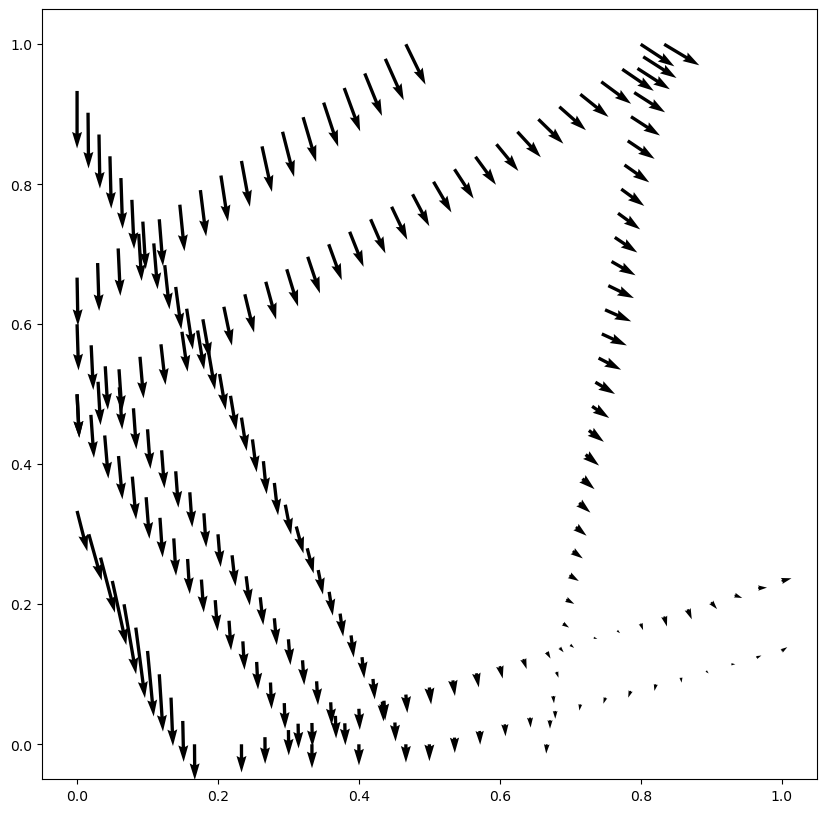

In [139]:
plt.figure(figsize = (10, 10))
plt.quiver(
    x_input[:, 0].detach(),  # x coordinates
    x_input[:, 1].detach(),  # y coordinates
    x_train_branching[:, 0].detach(),  # u component of the field
    x_train_branching[:, 1].detach(),  # v component of the field
    color = 'black',
)

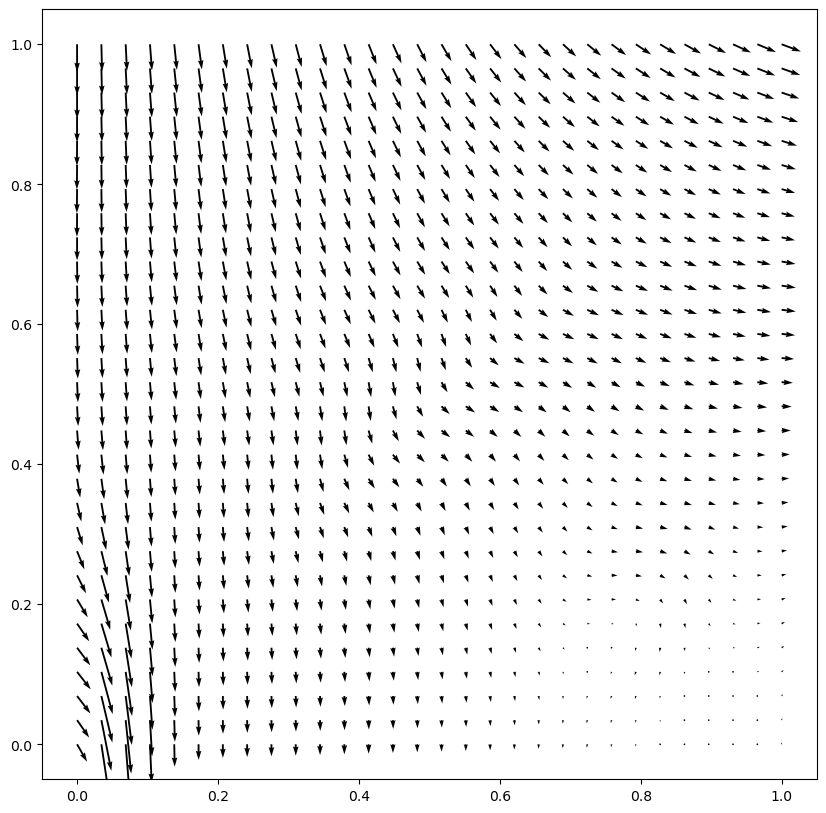

In [140]:
plt.figure(figsize = (10, 10))
plt.quiver(
    x_test[:, 0].detach(),  # x coordinates
    x_test[:, 1].detach(),  # y coordinates
    x_test_branching[:, 0].detach(),  # u component of the field
    x_test_branching[:, 1].detach(),  # v component of the field
    color = 'black',
)

In [ ]:
def simulate_detailed_deflection(x_inputs):
    x_inputs = x_inputs.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl
    
    # produce Unnormalised Gaussian Mixture component 
    ugm = compose_unnormalised_gaussian_mixture_long(
        x_inputs,
        list_of_mus,
        list_of_sigmas,
        list_of_weights
    ) # shape: (n)
    
    # produce baseline stream field
    bls = get_directed_bls_long(x_inputs, angle_degree = 90) # shape: (n)

    # stream function: weighted sum of the BLS and UGM
    psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight) # shape: (n)

    psi_vector_field = get_vector_field_from_stream_long(x_inputs, psi) # shape: (n, 2)

    simulated_vector_field = simulate_merge(x_inputs.detach().clone()) # torch.Size([n, 2])

    vector_field = psi_vector_field * 0.2 + simulated_vector_field # torch.Size([n, 2])

    return vector_field

def compose_unnormalised_gaussian_mixture_long(x, mus, sigmas, weights):
    """ Compose an unnormalised Gaussian mixture (UGM) from multiple Gaussian components. Returns a vector of the same length as x.

    Args:
        x (torch.Size([n, 2])): list of n points in 2D where the last two dims are the x and y coordinates
        mus (list of torch.Size([2])): list of mean locations of the Gaussian components
        sigmas (list of torch.Size([2, 2])): list of covariance matrices of the Gaussian components
        weights (list of float): list of weights for each Gaussian component

    Returns:
        pdf (torch.Size([n])): pdf of the UGM at each point
    """
    # Extract length for intialisation of placeholder
    n = x.shape[0] 

    # Unnormalised Gaussian Mixture Model (UGM) is a weighted sum of the individual Gaussian components
    ugm = torch.zeros(n) # shape: (n, )

    for mu, sigma, weight in zip(mus, sigmas, weights):
        ugm += weight * get_pdf_of_gaussian_component_long(x, mu, sigma)

    return ugm

def get_directed_bls_long(x, angle_degree):
    """
    Generate a linear stream function (scalar field) based on the x coordinates
    The stream function is directed in a specified angle (in degrees).
    Args:
        x (torch.Size([n, 2])): x coordinate list where the last two dims are the x and y coordinates
        angle_degree (float): angle in degrees for the direction of the stream function
    Returns:
        directed_stream (torch.Size([n])): directed stream function at each point
    """
    # Convert the angle from degrees to radians
    angle_rad = torch.deg2rad(torch.tensor(angle_degree))

    a = torch.cos(angle_rad)  # x weight
    b = torch.sin(angle_rad)  # y weight

    # stream(x, y) = a * x + b * y
    directed_stream = a * x[:, 0] + b * x[:, 1] # shape: (n)
    
    return directed_stream

ugm = compose_unnormalised_gaussian_mixture_long(
    x_input,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

torch.Size([196])


RuntimeError: The size of tensor a (128) must match the size of tensor b (196) at non-singleton dimension 1

# (2) New (merge &) curve with detail

In [15]:
## reproducing previous example
list_of_mus = [
    torch.tensor([0.4, 0.7]),
    #torch.tensor([0.9, 0.1]),
    torch.tensor([0.2, -0.05]),
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.05, 0.03], [0.002, 0.01]]),
    #torch.tensor([[0.8, 0.0], [0.0, 0.1]]),
    torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
    ]

list_of_weights = [
    0.2, 
    #-1.5,
    -1.0
    ] 

bsl_angle = 0
solid_ugm_weight = 0.5

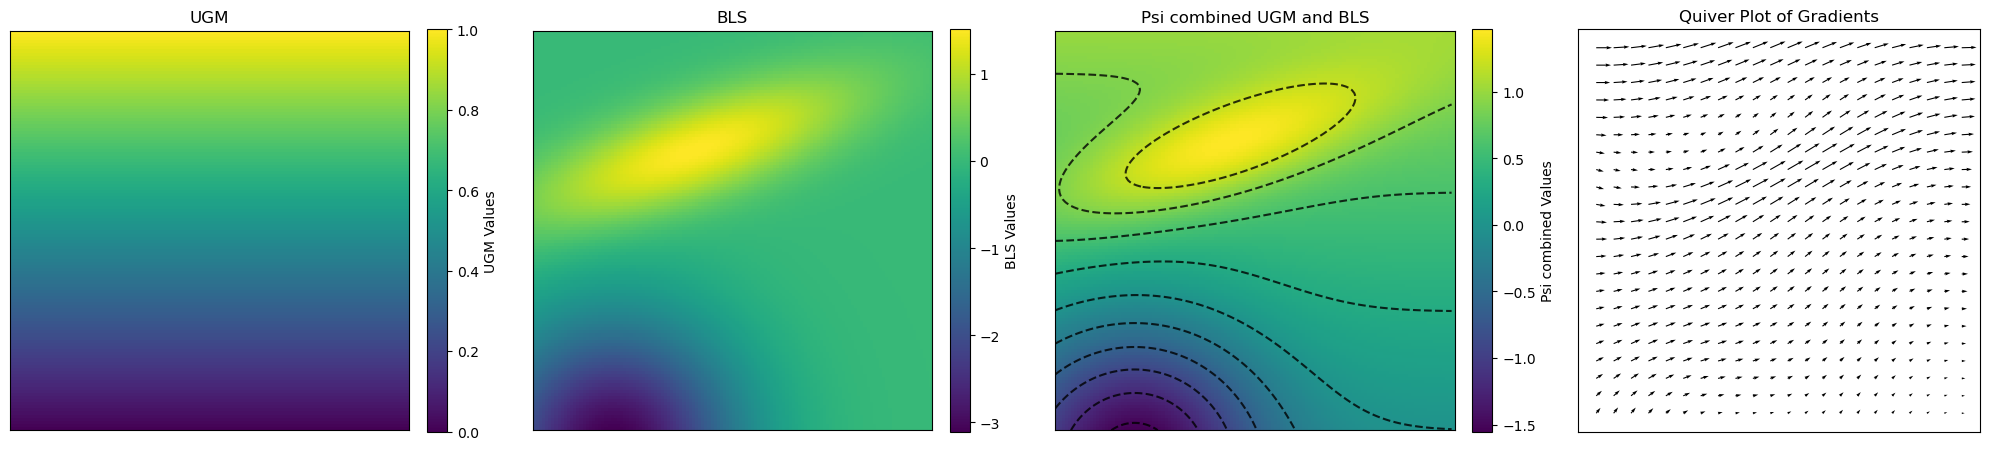

In [196]:
x_grid = x_grid.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl

ugm = compose_unnormalised_gaussian_mixture(
    x_grid,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

bls = get_directed_bls(x_grid, angle_degree = 90)
                          
# stream function
psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight)

vector_field = get_vector_field_from_stream(x_grid, psi)

simulated_vector_field = simulate_merge(x_grid.detach().clone().reshape(-1, 2)).reshape(N_SIDE, N_SIDE, 2)

vector_field = vector_field * 0.2 + simulated_vector_field 

make_four_plots(x_grid, bls, ugm, psi, vector_field)

# (3) More interesting convergence

In [246]:
## reproducing previous example
list_of_mus = [
    torch.tensor([0.2, 0.3]),
    torch.tensor([0.5, 1.0]),
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.05, 0.0], [0.01, 0.05]]),
    torch.tensor([[0.2, 0.0], [0.0, 0.1]]),
    ]

list_of_weights = [
    -0.2, 
    1.2,
    ] 

bsl_angle = 0
solid_ugm_weight = 0.5

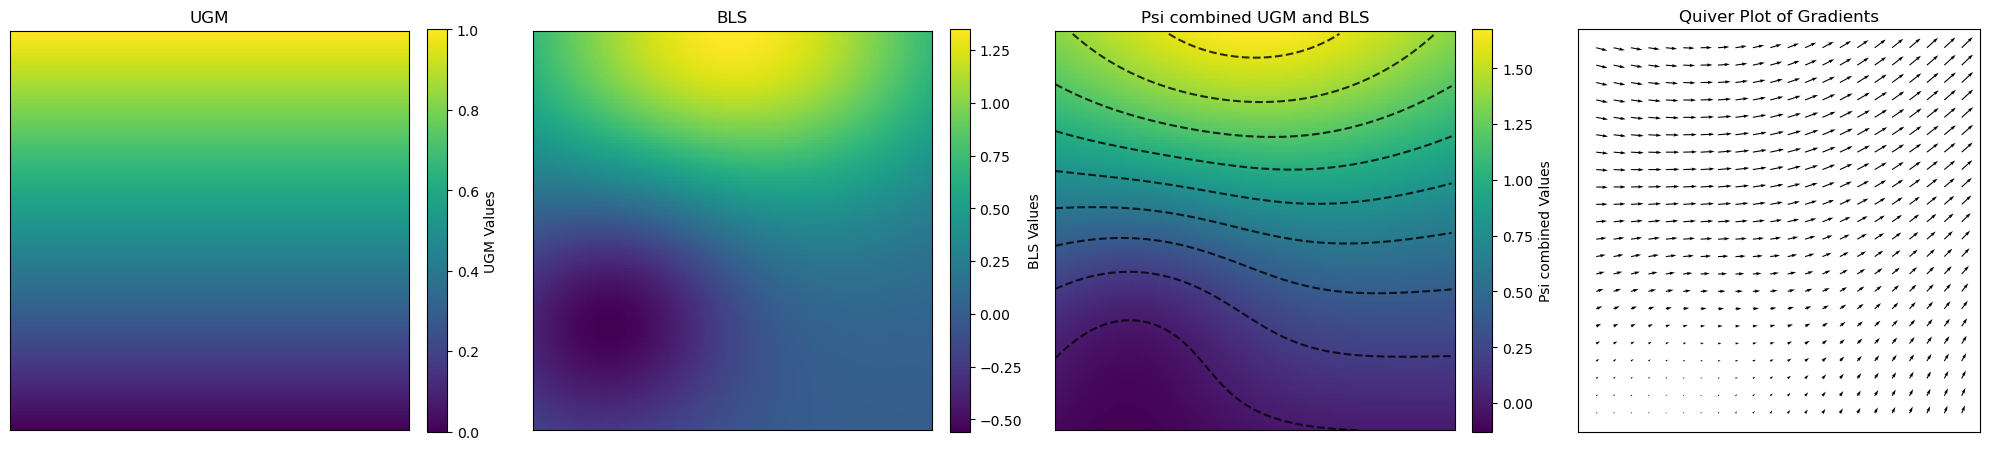

In [247]:
x_grid = x_grid.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl

ugm = compose_unnormalised_gaussian_mixture(
    x_grid,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

bls = get_directed_bls(x_grid, angle_degree = 90)
                          
# stream function
psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight)

vector_field = get_vector_field_from_stream(x_grid, psi)

simulated_vector_field = simulate_convergence(x_grid.detach().clone().reshape(-1, 2)).reshape(N_SIDE, N_SIDE, 2)

vector_field = vector_field * 0.4 + simulated_vector_field 

make_four_plots(x_grid, bls, ugm, psi, vector_field)

# (4) ridges

In [311]:
## reproducing previous example
list_of_mus = [
    torch.tensor([0.2, 0.3]),
    torch.tensor([0.5, 1.0]),
    torch.tensor([1.0, 0.7]),
    torch.tensor([1.0, 0.2]),
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.05, 0.0], [0.01, 0.1]]),
    torch.tensor([[0.2, 0.0], [0.0, 0.1]]),
    torch.tensor([[0.3, 0.0], [0.0, 0.01]]),
    torch.tensor([[0.3, 0.0], [0.0, 0.01]]),
    ]

list_of_weights = [
    -0.2, 
    1.2,
    0.2,
    0.2
    ] 

bsl_angle = 0
solid_ugm_weight = 0.1

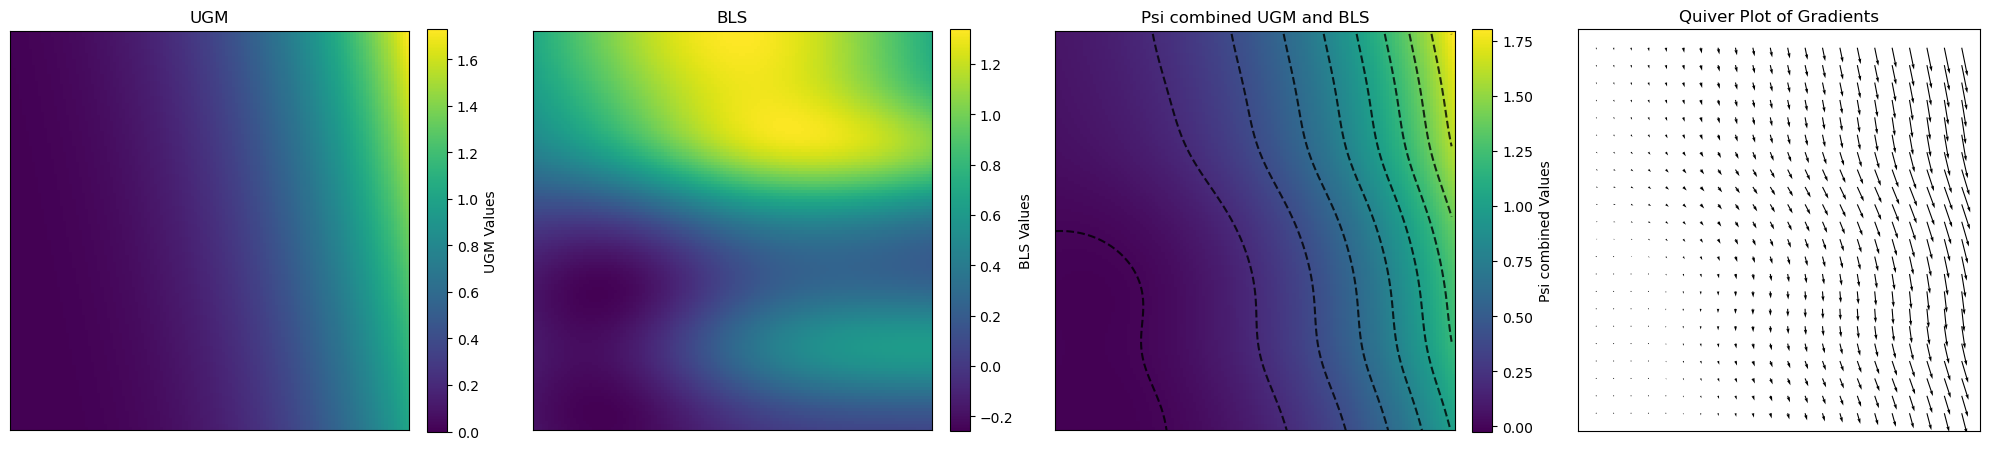

In [312]:
x_grid = x_grid.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl

ugm = compose_unnormalised_gaussian_mixture(
    x_grid,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

bls = (x_grid[:, :, 0] + 0.2 * x_grid[:, :, 1])**3
                          
# stream function
psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight)

vector_field = get_vector_field_from_stream(x_grid, psi)

vector_field = vector_field 

make_four_plots(x_grid, bls, ugm, psi, vector_field)

# (5) Branching

In [134]:
## reproducing previous example
list_of_mus = [
    torch.tensor([0.0, -0.1]),
    torch.tensor([0.5, 1.0]),
    torch.tensor([1.0, 0.7]),
    torch.tensor([0.5, 0.5]),
    torch.tensor([0.8, 0.2]),
    ]

# Covariance matrices for each Gaussian component
# Smaller: Lower variance (more concentrated) in that direction
# Off-diagonal elements: Correlation between x and y
list_of_sigmas = [
    torch.tensor([[0.003, 0.0], [0.0, 0.04]]),
    torch.tensor([[0.05, 0.0], [0.0, 0.05]]),
    torch.tensor([[0.3, 0.0], [0.0, 0.01]]),
    torch.tensor([[0.006, 0.0], [0.008, 0.004]]),
    torch.tensor([[0.004, 0.004], [0.0, 0.006]]),
    ]

list_of_weights = [
    - 0.8, 
    0.5,
    0.3,
    0.03,
    -0.03
    ] 

bsl_angle = 0
solid_ugm_weight = 0.2

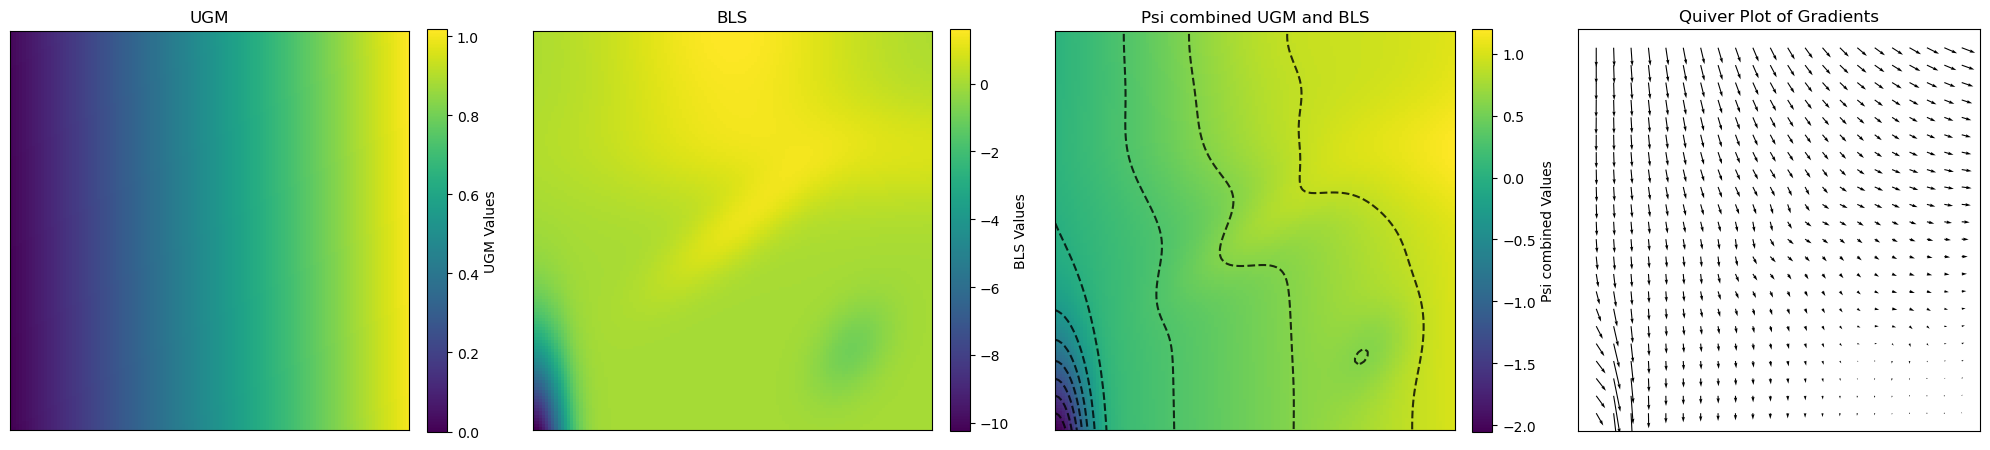

In [135]:
x_grid = x_grid.requires_grad_() # Set requires_grad to True for gradients i.e. to calculate the curl

ugm = compose_unnormalised_gaussian_mixture(
    x_grid,
    list_of_mus,
    list_of_sigmas,
    list_of_weights
)

# bls = torch.zeros_like(ugm)
bls = get_directed_bls(x_grid, angle_degree = 1)
   
# stream function
psi = combine_bls_and_ugm(bls, ugm, ugm_weight = solid_ugm_weight)

vector_field = get_vector_field_from_stream(x_grid, psi)

simulated_vector_field = simulate_branching(x_grid.detach().clone().reshape(-1, 2)).reshape(N_SIDE, N_SIDE, 2)

vector_field = vector_field * 0.1 + simulated_vector_field 

make_four_plots(x_grid, bls, ugm, psi, vector_field)

# Scalar fields to construct quiver plots

- A cone scalar field gives a full swirl.
- The stream function is a scalar field whose gradient gives the velocity field.


In 2D, any smooth, divergence-free vector field q(x,y) can be written as the rotated gradient of a scalar function ψ(x,y), often called the stream function.

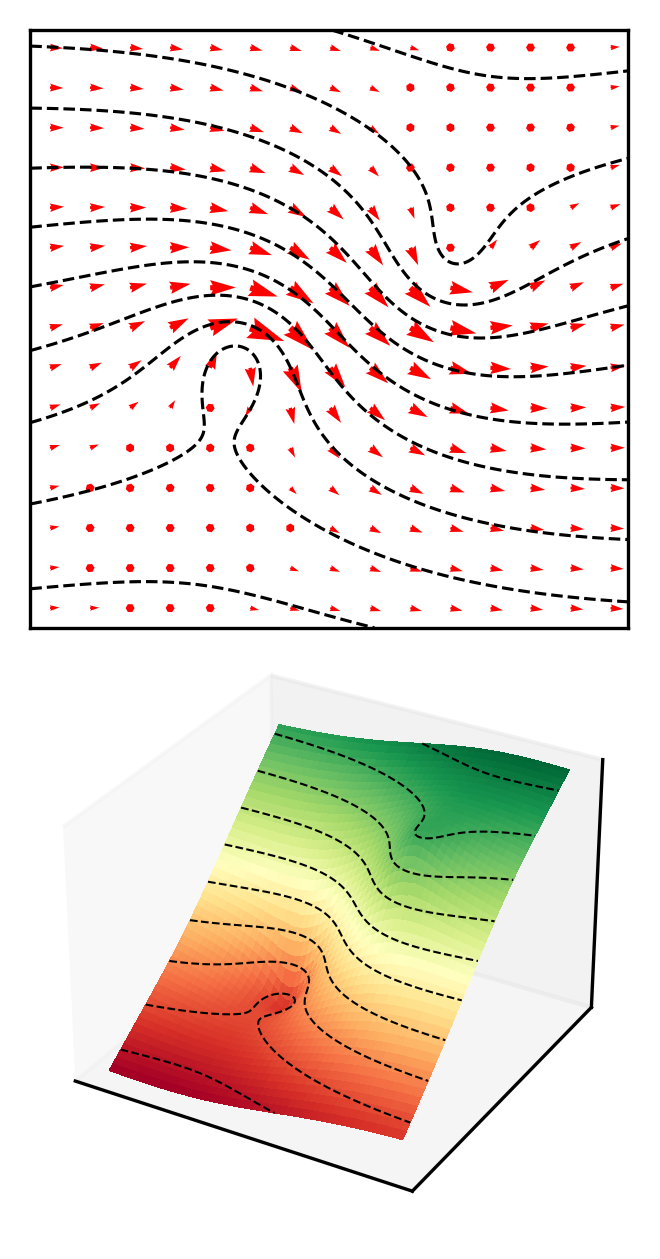

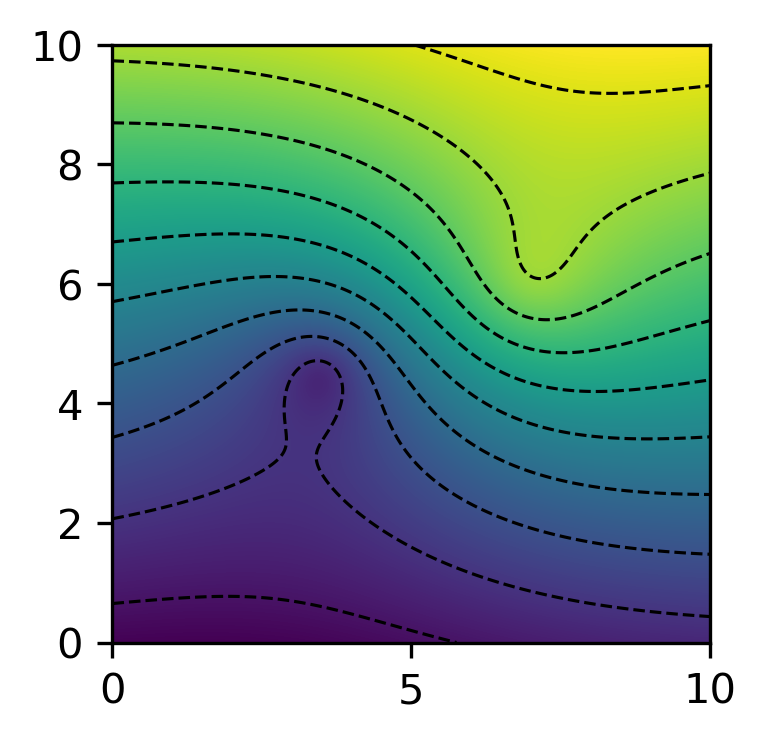

In [77]:
import numpy as np

# make a 1001 x 1001 grid
x = np.linspace(0, 10, 1001)
y = np.linspace(0, 10, 1001)[:, None] # extra dim

dx = x[1] - x[0] # step size 0.01 
dy = y[1, 0] - y[0, 0] # step size 0.01 

# if x are the grid points at the centroids of the cells, then
# the grid points are at the edges of the cells
extent = (x[0] - 0.5*dx, x[-1] + 0.5*dx, y[0,0] - 0.5*dy, y[-1,0] + 0.5*dy)

# Vortex
def vort(x0, y0, r):
	return - np.log(np.sqrt((x - x0)**2 + (y - y0)**2 + r**2))

# construct some stream function with
# overall background flow in x direction (right): 0 to 1.5
streamfunc = 0 * x + 0.15 * y
# put an irrotational vortex (singular) with negative vorticity, r is radius
streamfunc -= 0.30 * vort(3.5, 4.5, 0.5)
# make a spread-out vortex with positive vorticity
streamfunc += 0.30 * vort(7, 6, 0.8)

streamfunc = streamfunc

# Create a hole in the domain by cutting off the singular vortex
# streamfunc[(streamfunc < (+0.0)) & (y >2)] = np.nan
streammin = np.nanmin(streamfunc)
streammax = np.nanmax(streamfunc)

# calculate velocities; just forward difference for laziness.
ux = np.diff(streamfunc, axis = 0) / dy
uy = np.diff(streamfunc, axis = 1) / -dx


Nlevels = 9
contour_levels = (np.arange(0.5,(Nlevels+1))/(Nlevels+1)) * (streammax - streammin) + streammin


fig = plt.figure(figsize=(2,4), dpi=300)

# bottom axes: 3D plot 
ax = fig.add_axes((0, 0, 1, 0.5), projection = '3d', computed_zorder = False)
ax.view_init(30, -60, 0)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.plot_surface(x, y, streamfunc, cmap='RdYlGn',
                       linewidth=0, antialiased=False,
                       )
ax.contour(x, y[:,0], streamfunc, levels=contour_levels, colors='k', linestyles='--', linewidths=0.5, zorder=1000)

ax = plt.axes((0,0.5,0.997,0.5))
ax.set_xticks([])
ax.set_yticks([])
# draw the hole in the domain as gray
plt.imshow(np.isnan(streamfunc), origin = 'lower', extent = extent, cmap = 'gray_r', vmin = 0, vmax = 4)

# plot every 67th velocity arrow
slicer = slice(33, None, 67)
plt.quiver(x[slicer], y[slicer,:], ux[slicer,slicer], uy[slicer,slicer], scale=8., width=0.015, color='red')
plt.contour(x,y[:,0], streamfunc, levels = contour_levels, colors = 'k', linestyles='--', linewidths=0.75)
fig.savefig('stream function.png')


fig = plt.figure(figsize=(2,2), dpi=300)
ax = plt.axes((0,0,0.997,1))
plt.imshow(streamfunc, extent=extent, origin='lower')
plt.contour(x,y[:,0], streamfunc, levels=contour_levels, colors='k', linestyles='--', linewidths=0.75)
fig.savefig('stream function imshow.png')